### Importing Libraries

In [1]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import (
    Dense,
    GlobalAveragePooling2D,
    BatchNormalization,
    Dropout
)
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf
tf.random.set_seed(42)

/home/saad-bscs/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2023-12-11 23:28:56.750875: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-11 23:28:56.804548: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler fla

### Constants

In [2]:
img_height, img_width = 128, 128
batch_size = 32
num_classes = 124
data_dir = os.path.join(os.getcwd(), "gei/")

### Training Data Augmentation

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.15,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    brightness_range=[0.8, 1.2],
    channel_shift_range=10,
    zoom_range=[0.8, 1.2],
)

### Testing Data Augmentation

In [4]:
test_datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.15)

### Load and split data into training and testing sets

In [5]:
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=True,
    seed=42,
)

test_generator = test_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=False,
    seed=42,
)

Found 11555 images belonging to 124 classes.
Found 1967 images belonging to 124 classes.


### Load pre-trained ResNet50 without top layers

In [6]:
base_model = ResNet50(
    weights="imagenet", include_top=False, input_shape=(img_height, img_width, 3)
)

2023-12-11 23:28:59.637558: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Add custom classification layers

In [7]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu", kernel_regularizer=l2(0.003))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu", kernel_regularizer=l2(0.003))(x)
predictions = Dense(num_classes, activation='linear',
                    kernel_regularizer=l2(0.003))(x)

### Create the model

In [8]:
model = Model(inputs=base_model.input, outputs=predictions)

### Fine Tune the layers

In [9]:
for layer in model.layers:
    layer.trainable = True

### Compile the model

In [10]:
model.compile(
    optimizer=RMSprop(
        learning_rate=1e-4,
        rho=0.9,
        momentum=0.0,
        epsilon=1e-07,
        centered=False,
        name="RMSprop",
    ),
    loss=CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

### Train the model

In [11]:
history = model.fit(train_generator, epochs=50, validation_data=test_generator)

Epoch 1/50
362/362 [==============================] - 234s 614ms/step - loss: 12.8659 - accuracy: 0.0126 - val_loss: 12.7530 - val_accuracy: 0.0056
Epoch 2/50
362/362 [==============================] - 219s 605ms/step - loss: 11.7730 - accuracy: 0.0510 - val_loss: 12.7284 - val_accuracy: 0.0081
Epoch 3/50
362/362 [==============================] - 219s 605ms/step - loss: 10.5860 - accuracy: 0.1233 - val_loss: 11.6462 - val_accuracy: 0.0442
Epoch 4/50
362/362 [==============================] - 218s 603ms/step - loss: 9.5482 - accuracy: 0.2260 - val_loss: 9.6935 - val_accuracy: 0.1881
Epoch 5/50
362/362 [==============================] - 218s 601ms/step - loss: 8.5966 - accuracy: 0.3312 - val_loss: 8.7364 - val_accuracy: 0.2974
Epoch 6/50
362/362 [==============================] - 220s 607ms/step - loss: 7.7654 - accuracy: 0.4276 - val_loss: 8.6996 - val_accuracy: 0.2572
Epoch 7/50
362/362 [==============================] - 219s 604ms/step - loss: 6.9991 - accuracy: 0.5250 - val_loss: 8.

### Evaluate model on training set

In [12]:
train_loss, train_accuracy = model.evaluate(train_generator)
print(f"Training accuracy: {train_accuracy}")

362/362 [==============================] - 100s 276ms/step - loss: 0.6492 - accuracy: 0.9534
Training accuracy: 0.9534400701522827


### Evaluate model on testing set

In [13]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Testing accuracy: {test_accuracy}")

62/62 [==============================] - 12s 188ms/step - loss: 1.1872 - accuracy: 0.8226
Testing accuracy: 0.8225724697113037


### Save the model

In [14]:
model.save('ResNet50.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Model Summary

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

### Plot Training & Validation Accuracy

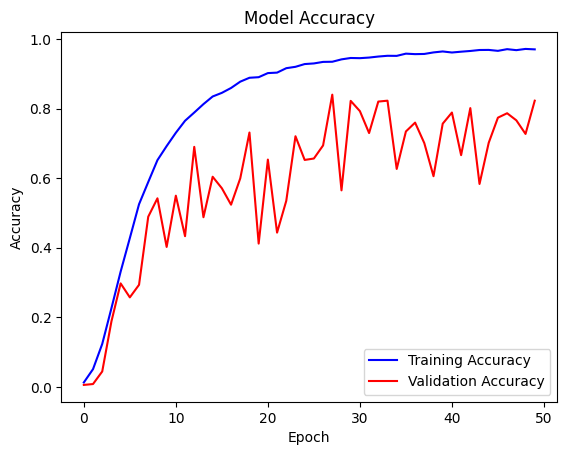

In [16]:
plt.plot(history.history['accuracy'], color='blue', label='Training Accuracy')
plt.plot(history.history['val_accuracy'],
         color='red', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Plot Training and Validation Loss

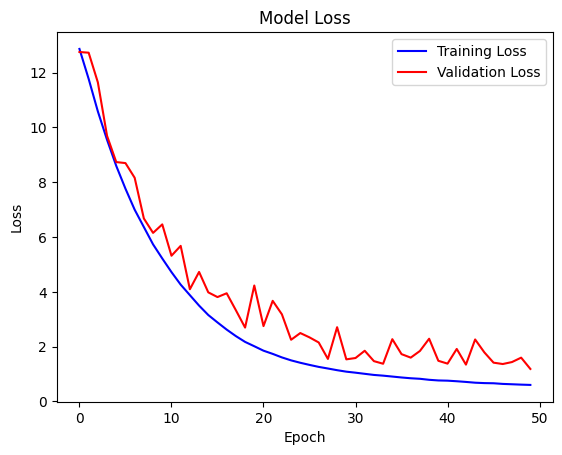

In [3]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], color='blue', label='Training Loss')
plt.plot(history.history['val_loss'],
         color='red', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()